[*********************100%***********************]  1 of 1 completed


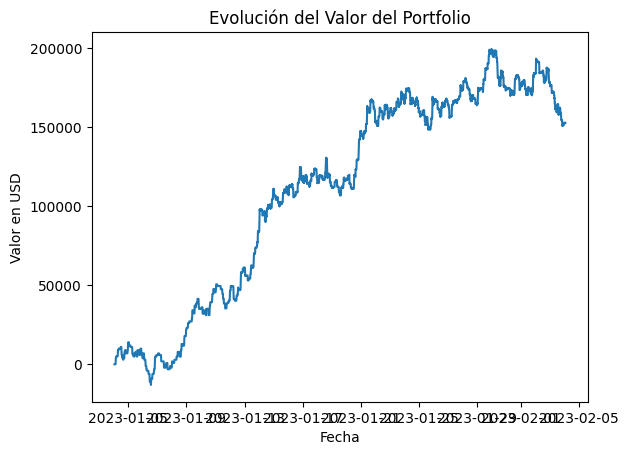

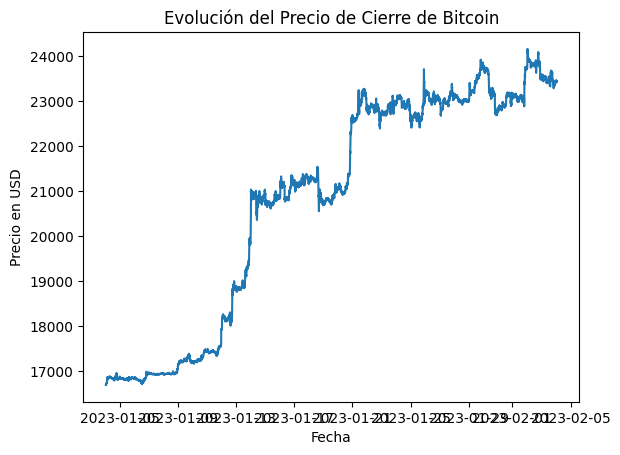

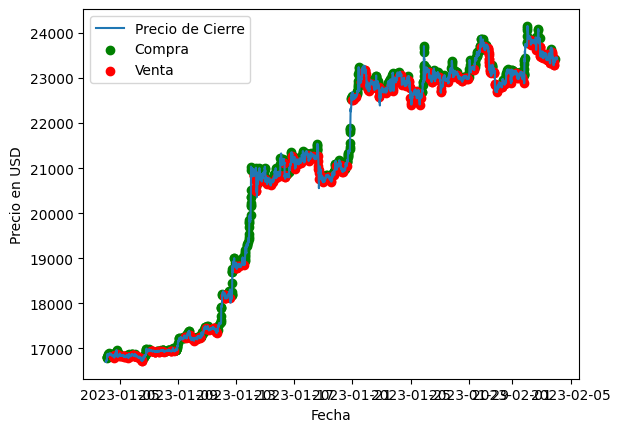

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Descargar los datos históricos de Bitcoin
btc = yf.download('BTC-USD', period="1mo", interval="5m")

# Agregar las bandas de Bollinger
window = 20
no_of_std = 2
btc['MA20'] = btc['Close'].rolling(window=window).mean()
btc['Upper_Band'] = btc['MA20'] + no_of_std * btc['Close'].rolling(window=window).std()
btc['Lower_Band'] = btc['MA20'] - no_of_std * btc['Close'].rolling(window=window).std()

# Agregar las señales de compra y venta
btc['Buy'] = (btc['Close'] > btc['Upper_Band']).astype(int)
btc['Sell'] = (btc['Close'] < btc['Lower_Band']).astype(int)

# Agregar la evolución del portfolio
btc['Shares'] = (btc['Buy'] * 1000 / btc['Close']) - (btc['Sell'] * 1000 / btc['Close'])
btc['Shares'] = btc['Shares'].cumsum()
btc['Portfolio Value'] = btc['Shares'] * btc['Close']

# Mostrar la evolución del valor del portfolio
plt.plot(btc['Portfolio Value'])
plt.title('Evolución del Valor del Portfolio')
plt.xlabel('Fecha')
plt.ylabel('Valor en USD')
plt.show()

# Mostrar la evolución del precio de cierre de Bitcoin
plt.plot(btc['Close'])
plt.title('Evolución del Precio de Cierre de Bitcoin')
plt.xlabel('Fecha')
plt.ylabel('Precio en USD')
plt.show()

# Mostrar las señales de compra y venta en el precio de cierre de Bitcoin
plt.plot(btc['Close'], label='Precio de Cierre')
plt.scatter(btc.loc[btc['Buy'] == 1].index, btc.loc[btc['Buy'] == 1]['Close'], color='g', label='Compra')
plt.scatter(btc.loc[btc['Sell'] == 1].index, btc.loc[btc['Sell'] == 1]['Close'], color='r', label='Venta')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Precio en USD')
plt.show()